How do integrate functions approximately, and get some idea of the expected error in the integral at the same time? Let's start with a function we can integrate

$ f(x) = x^3 - 2x + 1$

and assume we need to integrate it between the limits (0,1) 

y = $ \int_0^1  x^3 - 2x + 1 dx $


In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def func(x):
    return x*x*x - 2*x + 1

In [3]:
xs = np.linspace(0,1)
ys = func(xs)

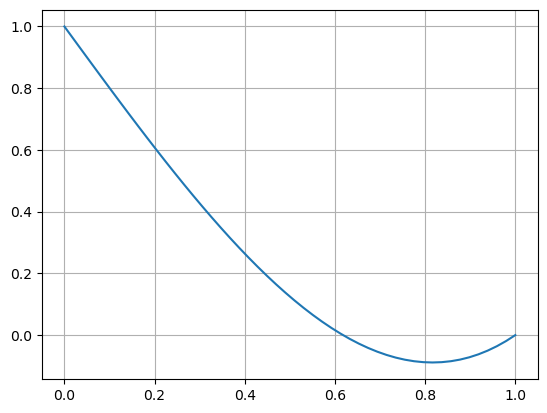

In [4]:
plt.plot(xs,ys)
plt.grid()
plt.show()

We know that the indefinite integral of this integrand is:

$y = 1/4x^4 - x^2 + x $

so the integral between the limits is

$ 1/4*1 - 1 + 1 - 0 = 0.25$

A naive approximation to this is a riemman sum

In [5]:
xs = np.linspace(0,1,10)
ys = func(xs)
I_est = np.sum(ys*np.hstack([0,np.diff(xs)]))
print('Riemann sum 10 pts: ',I_est)

Riemann sum 10 pts:  0.19753086419753088


We can make this more accurate by increasing the number of samples we evaluate the integrand at

In [6]:
xs = np.linspace(0,1,100)
ys = func(xs)
I_est = np.sum(ys*np.hstack([0,np.diff(xs)]))
print('Riemann sum 1000 pts: ',I_est)

Riemann sum 1000 pts:  0.24497500255076013


In [7]:
xs = np.linspace(0,1,1000)
ys = func(xs)
I_est = np.sum(ys*np.hstack([0,np.diff(xs)]))
print('Riemann sum 10000 pts: ',I_est)

Riemann sum 10000 pts:  0.2494997500002505


Or, we could try a function approximation scheme, where we fit a curve through the sampled points, and integrate this. For example, the trapezium rule gets much closer to the true answer with only a few samples.

In [8]:
xs = np.linspace(0,1,10)
ys = func(xs)
I_est = np.trapz(ys,xs)
print('Trapezoidal rule 10 pts: ',I_est)

Trapezoidal rule 10 pts:  0.25308641975308643


The trapezoid rule fits straight line segments between samples, but we could fit other functions too. For example, a Gaussian process, with a kernel function that specifies how the values of samples near each other affect the possible curves that could be fit through a point.

The example below shows an radial basis function kernel. Points closer to each other have a stronger effect than points further away. The Gaussian process assumes that each point of the curve fit is a Gaussian, so can also produce an uncertainty at this point.

In [9]:
def rbf(x1,x2,sigma=0.15):
    
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(1,-1)
    dists = (x1-x2)**2
    
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-dists/(2*sigma**2))

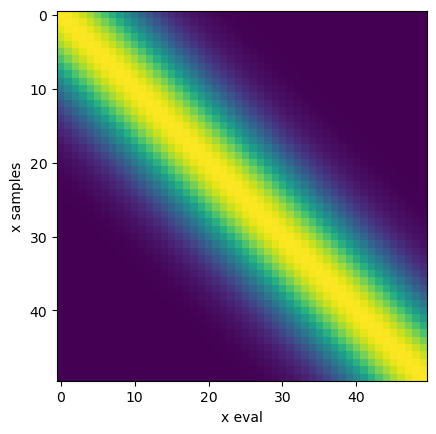

In [10]:
cxx = rbf(np.linspace(0,1),np.linspace(0,1))
plt.imshow(cxx)
plt.ylabel('x samples')
plt.xlabel('x eval')
plt.show()

In [11]:
def gp_predict(xs,ys,x_eval,kernel):
    
    x_eval = x_eval.reshape(-1,1)
    ys = ys.reshape(-1,1)
    
    mu = kernel(x_eval,xs)@np.linalg.inv(kernel(xs,xs))@ys
    sig = kernel(x_eval,x_eval) - kernel(x_eval,xs)@np.linalg.inv(kernel(xs,xs))@kernel(xs,x_eval)
    return mu.ravel(), sig + 1e-9*np.eye(sig.shape[0]) #Add small diagonal uncertainty to fix numerical issues

A GP with an RBF kernel fits a curve through sampled points, by summing up the contributions of each sample, in proportion to how far they are from the evaluated point. Each slice through the curve fit is a Gaussian, with some uncertainty. This grows between samples, because we aren't sure what the true value is.

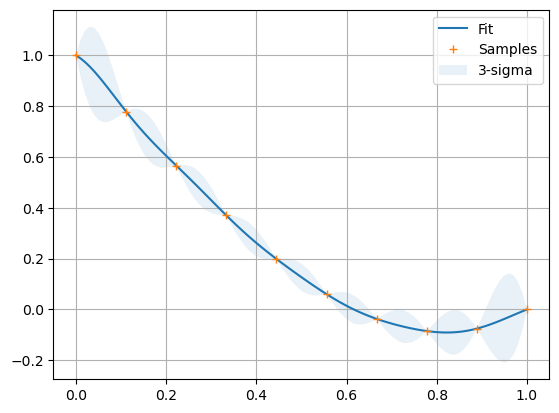

In [12]:
xs = np.linspace(0,1,10)
ys = func(xs)
x_eval = np.linspace(0,1,100)
mu_eval,var_eval = gp_predict(xs,ys,x_eval,kernel=rbf)
sig_diag = np.sqrt(np.diag(var_eval))
plt.plot(x_eval,mu_eval,label='Fit')
plt.plot(xs,ys,'+',label='Samples')
plt.fill_between(x_eval,mu_eval-3*sig_diag,mu_eval+3*sig_diag,alpha=0.1,label='3-sigma')
plt.legend()
plt.grid()
plt.show()

OK, so we can approximate our integrand with a GP and this gives us an idea of the uncertainty in the function. But it turns out we can often also integrate GPs analytically, depending on the kernel and get an estimate of uncertainty. This is called Bayesian quadrature. Lets do this for the RBF case above, between the limits 0 and 1. I solved for these equations by hand, so may be some errors, see derivation below.

Lets start by deriving the mean of the integral:

$v[k] = \int_0^1 k(y,x) dy$

$v[k] = \int_0^1 \frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{(x-y)^2}{2\sigma^2}) dy$

Integrating a Gaussian is hard, but other people have done it using the erf function (see CDF of Gaussian)

$ v[k(y,x)] = \frac{1}{2}(1+\text{erf}(\frac{1-x}{\sigma\sqrt{2}})) - \frac{1}{2}(1+\text{erf}(\frac{0-x}{\sigma\sqrt{2}}))$

$ v[k(y,x)] = \frac{1}{2}\text{erf}(\frac{1-x}{\sigma\sqrt{2}}) - \frac{1}{2}(\text{erf}\frac{0-x}{\sigma\sqrt{2}})$

Ok, for the uncertainty we have to integrate again. 

$vv[k] = \int_0^1 \int_0^1 k(x,y) dxdy$

$vv[k] = \int_0^1 \frac{1}{2}\text{erf}(\frac{1-y}{\sigma\sqrt{2}}) - \frac{1}{2}\text{erf}(\frac{0-y}{\sigma\sqrt{2}})dy$

This needs some tricky integration by substitution. Let $u_1 = \frac{1-y}{\sigma\sqrt{2}}$ and $u_2 = \frac{-y}{\sigma\sqrt{2}}$. Then

$vv[k] = \int_0^1 \frac{1}{2}\text{erf}(u_1)dy - \int_0^1\frac{1}{2}\text{erf}(u_2)dy$

$vv[k] = \int_0^1 \frac{1}{2}\text{erf}(u_1)\frac{-1}{\sigma\sqrt{2}}\frac{\sigma\sqrt{2}}{-1} dy - \int_0^1\frac{1}{2}\text{erf}(u_2)\frac{-1}{\sigma\sqrt{2}}\frac{\sigma\sqrt{2}}{-1}dy$

$vv[k] = \int_0^1 \frac{1}{2}\frac{\sigma\sqrt{2}}{-1}\text{erf}(u_1)du_1 - \int_0^1\frac{1}{2}\frac{\sigma\sqrt{2}}{-1}\text{erf}(u_2)du_2$

$vv[k] = \frac{1}{2}\frac{\sigma\sqrt{2}}{-1}(\int_0^1 \text{erf}(u_1)du_1 - \int_0^1\text{erf}(u_2)du_2) |_0^1$

Simplifying, gives us the final result, which can be evaluated at 1 and 0.

$vv[k] = \frac{1}{2}\frac{\sigma\sqrt{2}}{-1}( u_1\text{erf}(u_1) + \frac{\exp{-u_1^2}}{\sqrt{\pi}} - u_2\text{erf}(u_2) - \frac{\exp{-u_2^2}}{\sqrt{\pi}}) |_0^1$



In [13]:
from scipy.special import erf

In [39]:
def vf(x,sig=0.15):
    # cdf of Gaussian
    return 0.5*erf((1-x)/(sig*np.sqrt(2))) - 0.5*erf((-x)/(sig*np.sqrt(2)))

def vff_part(y,sig=0.15):
    u1 = (1-y)/(sig*np.sqrt(2))
    I1 = (u1*erf(u1)+ np.exp(-u1*u1)/np.sqrt(np.pi))
    u2 = (-y)/(sig*np.sqrt(2))
    I2 = (u2*erf(u2)+ np.exp(-u2*u2)/np.sqrt(np.pi))
    return (-0.5*sig*np.sqrt(2))*(I1-I2)

def vff(sig=0.15):
    return vff_part(1)- vff_part(0)

def integrate_rbf(x_eval,y_eval):
    
    x_eval = x_eval.reshape(-1,1)
    y_eval = y_eval.reshape(-1,1)
    
    kxx = rbf(x_eval,x_eval.T)
    
    mu = vf(x_eval).reshape(1,-1)@np.linalg.solve(kxx,y_eval)
    var = vff() - vf(x_eval).reshape(1,-1)@np.linalg.solve(kxx,vf(x_eval).reshape(-1,1))
    
    return mu, var
    

In [41]:
for npoints in [8,16,32,64]:
    xs = np.linspace(0,1,npoints)
    ys = func(xs)
    I_mu, I_var = integrate_rbf(xs,ys)
#     print(I_var)

    print('Bayesian Quadrature estimate (3 SD) %d pts: \n'%npoints,I_mu[0],'+-',3*np.sqrt(I_var))

Bayesian Quadrature estimate (3 SD) 8 pts: 
 [0.25370966] +- [[0.04172939]]
Bayesian Quadrature estimate (3 SD) 16 pts: 
 [0.25002941] +- [[0.00027914]]
Bayesian Quadrature estimate (3 SD) 32 pts: 
 [0.25] +- [[8.94069672e-08]]
Bayesian Quadrature estimate (3 SD) 64 pts: 
 [0.25] +- [[4.47034836e-08]]


As the number of samples increases we get closer to the true value, and the uncertainty decreases. This is neat, because it gives us a principled way to estimate the uncertainty of an integral. Note this uncertainty changes depending only on where we sample, so this can be precomputed if we sample at fixed places. 

Also, if we sampled randomly between 0 and 1 instead of evenly spaced between these, we can be much more certain/uncertain, depending on where the samples are.

In [53]:
xs = np.random.rand(8)
ys = func(xs)
I_mu, I_var = integrate_rbf(xs,ys)

print('Bayesian Quadrature estimate (3 SD) 8 random pts: \n',I_mu[0],'+-',3*np.sqrt(I_var))

Bayesian Quadrature estimate (3 SD) 8 random pts: 
 [0.24862544] +- [[0.17301901]]


### Doing this with a Matern Kernel

The rbf kernel above is very smooth, so interpolates between samples with a smooth function. But the real world is usually never smooth, so we can try to choose kernels that allow for more wiggly curves through samples. For example, a matern kernel:

In [16]:
 def matern(x1,x2,rho=1/5):
        x1 = x1.reshape(-1,1)
        x2 = x2.reshape(1,-1)
        return (1. + np.sqrt(3.)*np.abs(x1-x2)/rho)*np.exp(-np.sqrt(3.)*np.abs(x1-x2)/rho)

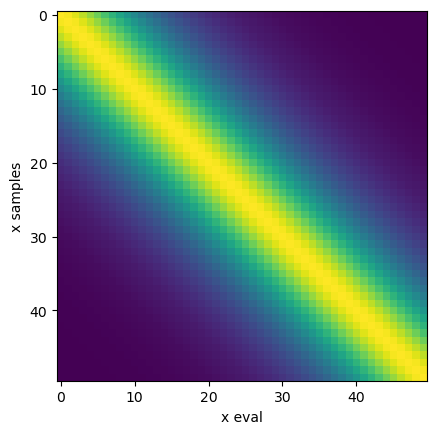

In [17]:
cxx = matern(np.linspace(0,1),np.linspace(0,1))
plt.imshow(cxx)
plt.ylabel('x samples')
plt.xlabel('x eval')
plt.show()

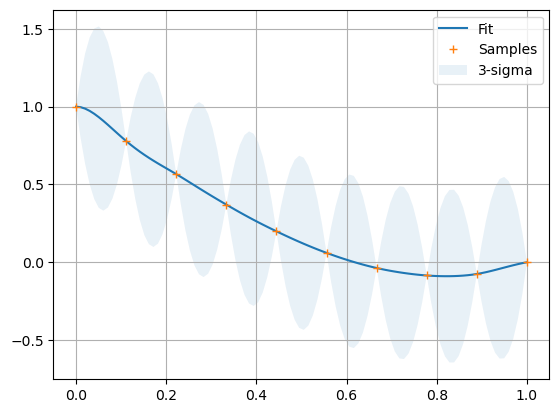

In [18]:
xs = np.linspace(0,1,10)
ys = func(xs)
x_eval = np.linspace(0,1,100)
mu_eval,var_eval = gp_predict(xs,ys,x_eval,kernel=matern)
sig_diag = np.sqrt(np.diag(var_eval))
plt.plot(x_eval,mu_eval,label='Fit')
plt.plot(xs,ys,'+',label='Samples')
plt.fill_between(x_eval,mu_eval-3*sig_diag,mu_eval+3*sig_diag,alpha=0.1,label='3-sigma')
plt.legend()
plt.grid()
plt.show()

Lets integrate for the Matern case above, between the limits 0 and 1.

In [19]:
def bayes_quad_mu(x,rho=1/5):

    y = 4.*rho/np.sqrt(3.) - 1./3.*np.exp(np.sqrt(3.)*(x-1.)/rho)*(3.+2.*np.sqrt(3.)*rho -3.*x) - 1./3.*np.exp(-np.sqrt(3.)/rho*x)*(3.*x + 2.*np.sqrt(3.)*rho)

    return y  

def bayes_quad_sig(rho=1/5):
    
    y = 2*rho/3*(2*np.sqrt(3) - 3*rho + np.exp(-np.sqrt(3)/rho)*(np.sqrt(3) + 3*rho))
    
    return y

def integrate_matern(x_eval,y_eval):
    
    x_eval = x_eval.reshape(-1,1)
    y_eval = y_eval.reshape(-1,1)
    
    kxx = matern(x_eval,x_eval.reshape(1,-1))
            
    bqm = bayes_quad_mu(x_eval.reshape(-1,1)).reshape(1,-1)
    bqs = bayes_quad_sig() - bqm@np.linalg.solve(kxx,bqm.T)
    
    mu = (bqm@np.linalg.solve(kxx,y_eval))
    
    return mu, bqs

In [42]:
for npoints in [8,16,32,64]:
    xs = np.linspace(0,1,npoints)
    ys = func(xs)
    I_mu, I_var = integrate_matern(xs,ys)

    print('Bayesian Quadrature estimate (3 SD) %d pts: \n'%npoints,I_mu[0],'+-',3*np.sqrt(I_var))

Bayesian Quadrature estimate (3 SD) 8 pts: 
 [0.25399818] +- [[0.12348279]]
Bayesian Quadrature estimate (3 SD) 16 pts: 
 [0.2506516] +- [[0.02682701]]
Bayesian Quadrature estimate (3 SD) 32 pts: 
 [0.25008989] +- [[0.0061499]]
Bayesian Quadrature estimate (3 SD) 64 pts: 
 [0.25001173] +- [[0.00146526]]


The function we are using for testing is very smooth, so not fit as well as with the RBF.